In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf

tf.enable_eager_execution()
tf.executing_eagerly()

True

In [4]:
x = [[2.]]
m = tf.matmul(x,x)
print("hello, {}".format(m))

hello, [[4.]]


In [7]:
a = tf.constant([[1,2],
                 [3,4]])
print(a)


tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [8]:
# Broadcasting support
b = tf.add(a,1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [10]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [11]:
import numpy as np
c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [15]:
print(a.numpy())
print(type(a.numpy()))

[[1 2]
 [3 4]]
<class 'numpy.ndarray'>


In [13]:
tfe = tf.contrib.eager

In [17]:
# Fizzbuzz
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1

In [18]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


In [73]:
# build a model
class MySimpleLayer(tf.keras.layers.Layer):
    def __init__(self, output_units):
        super(MySimpleLayer, self).__init__()
        self.output_units = output_units
        
    def build(self, input_shape):
        self.kernel = self.add_variable(
          "kernel", [input_shape[-1], self.output_units])
    
    def call(self, input):
        return tf.matmul(input, self.kernel)

In [74]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(784,)),
    tf.keras.layers.Dense(10)
])

In [75]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=10)
        self.dense2 = tf.keras.layers.Dense(units=10)
        
    def call(self, input):
        result = self.dense1(input)
        result = self.dense2(result)
        result = self.dense2(result) # Reuse variables from dense2 layer
        return result
    
model = MNISTModel()

In [77]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
    loss = w * w
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [78]:
# Train a model on the MNIST handwritten digit dataset
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [90]:
# Build Model
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
    tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

for images, labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.02854954  0.00563069  0.00935452  0.02136868 -0.03661004 -0.03393055
   0.02978056  0.02673863  0.00281314 -0.02233228]]


In [91]:
optimizer = tf.train.AdamOptimizer()
loss_history = []

In [92]:
for (batch, (images, labels)) in enumerate(dataset.take(400)):
    if batch % 10 == 0:
        print('.', end='')
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)
        
    loss_history.append(loss_value.numpy())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables),
                              global_step=tf.train.get_or_create_global_step())

........................................

Text(0, 0.5, 'Loss [entropy]')

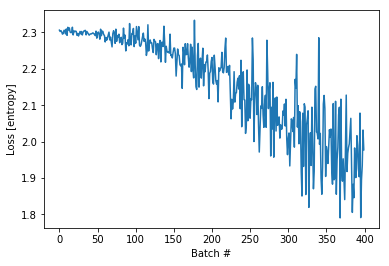

In [97]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [100]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    def call(self, inputs):
        return inputs * self.W + self.B

# A toy example of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random_normal([NUM_EXAMPLES])
noise = tf.random_normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.W, model.B])

# Define:
# 1. A model
# 2. Derivatives of a loss function with respect to model parameters
# 3. A strategy for updating the variables based ont he derivatives
model = Model()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# Training loop
for i in range(300):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]),
                              global_step=tf.train.get_or_create_global_step())
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))
print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 68.854
Loss at step 000: 66.160
Loss at step 020: 29.972
Loss at step 040: 13.868
Loss at step 060: 6.701
Loss at step 080: 3.512
Loss at step 100: 2.092
Loss at step 120: 1.461
Loss at step 140: 1.179
Loss at step 160: 1.054
Loss at step 180: 0.999
Loss at step 200: 0.974
Loss at step 220: 0.963
Loss at step 240: 0.958
Loss at step 260: 0.956
Loss at step 280: 0.955
Final loss: 0.954
W = 3.0330569744110107, B = 2.0255370140075684


In [101]:
if tf.test.is_gpu_available():
    with tf.device("gpu:0"):
        v = tf.Variable(tf.random_normal([1000, 1000]))
        v = None # v no longer takes up GPU memory